In [18]:
#Imports
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, \
                            confusion_matrix, accuracy_score


In [19]:
class DeepConvEncoder(nn.Module):
    def __init__(self):
        super(DeepConvEncoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fully_connected = nn.Linear(128 * 3 * 3, 12 * 12)  # Assuming 3x3 as the output size after pooling

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        # Flatten the output tensor before passing it through the fully connected layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fully_connected(x))
                
        return x


In [20]:
class DeepConvDecoder(nn.Module):
    def __init__(self, input_size):
        super(DeepConvDecoder, self).__init__() 
        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(144, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
        # Adjust the input size of the linear layer dynamically
        self.flat_size = input_size  # Use the provided input size

        # Calculate the correct input size for the linear layer based on the shape of the tensor
        self.calculate_input_size(input_size)

        # Update the input size in the initialization of the linear layer
        self.fully_connected = nn.Linear(self.flat_size, 28*28)  # Assuming MNIST images are of size 28x28

    def calculate_input_size(self, input_size):
        # Use the provided input size
        self.flat_size = input_size[0] * input_size[1] * input_size[2]  # Calculate the flat size based on height and width

    def forward(self, x):
        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        
        # Flatten the output tensor before passing it through the fully connected layer
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fully_connected(x))
        return x


In [27]:
# Initialize the decoder model with the input size (1, 28, 28)
decoder = DeepConvDecoder((1, 28, 28))
encoder = DeepConvEncoder()


In [22]:
class Channel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Channel, self).__init__()
        self.serialize = nn.Linear(input_dim, output_dim)  
        self.deserialize = nn.Linear(output_dim, input_dim)

    def forward(self, x):
        # Serialization
        x = self.serialize(x)
        
        # Deserialization
        x = self.deserialize(x)
        
        return x


In [23]:
# Initialize Channel module
channel = Channel(1152, 1152)


## Load MNIST data ##

In [24]:
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [25]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 64

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [28]:

model = nn.Sequential(encoder, channel, decoder)

# Specify loss function
criterion = nn.MSELoss()

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Encoder Epoch: 1 	Training Loss: 0.003086
Encoder Epoch: 2 	Training Loss: 0.003076
Encoder Epoch: 3 	Training Loss: 0.003070
Encoder Epoch: 4 	Training Loss: 0.003092
Encoder Epoch: 5 	Training Loss: 0.003083


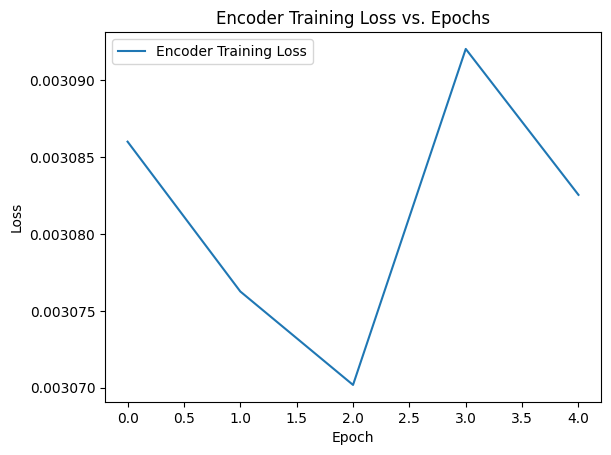

In [29]:
# Initialize an empty list to store the training losses
encoder_train_losses = []
decoder_train_losses = []

# Set the number of epochs
n_epochs = 5

# Training loop for encoder
for epoch in range(1, n_epochs+1):
    # monitor training loss for encoder
    encoder_train_loss = 0.0
    
    ###################
    # train the encoder #
    ###################
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        encoded_data = encoder(images)
        # Assuming encoded_data has shape (batch_size, num_features)
        num_features = encoded_data.size(1)

        # Initialize Channel module
        channel = Channel(num_features, num_features)

        encoded_data = channel(encoded_data)  
        
        # Some dummy target for the encoder (could be the input_data itself)
        dummy_target = torch.zeros_like(encoded_data)
        
        encoder_loss = criterion(encoded_data, dummy_target)
        encoder_loss.backward()
        optimizer.step()
        encoder_train_loss += encoder_loss.item() * images.size(0)
    
    # Calculate the average training loss for the epoch for encoder
    encoder_train_loss /= len(train_loader.dataset)
    encoder_train_losses.append(encoder_train_loss)
    
    # Print the average training loss for the epoch for encoder
    print('Encoder Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, encoder_train_loss))



# Plot the training loss as a function of epochs for encoder
plt.plot(encoder_train_losses, label='Encoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Encoder Training Loss vs. Epochs')
plt.legend()
plt.show()



In [37]:
decoder = DeepConvDecoder(input_size=64)

TypeError: 'int' object is not subscriptable

In [34]:
# Training loop for decoder
for epoch in range(1, n_epochs+1):
    # monitor training loss for decoder
    decoder_train_loss = 0.0
    
    ###################
    # train the decoder #
    ###################
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        
        # Forward pass through encoder
        encoded_data = encoder(images)
        
        # Forward pass through channel
        encoded_data = channel(encoded_data) 
        
        # Reshape encoded data appropriately for the decoder input
        encoded_data = encoded_data.view(encoded_data.size(0), encoded_data.size(1), 1, 1)
        
        # Reconstruct the data
        reconstructed_data = decoder(encoded_data)
        # Reshape reconstructed_data to match the size of images
        reconstructed_data_reshaped = reconstructed_data.view(images.size())
        # Compute the decoder loss
        decoder_loss = criterion(reconstructed_data_reshaped, images)
        decoder_loss.backward()
        optimizer.step()
        
        # Accumulate the decoder loss
        decoder_train_loss += decoder_loss.item() * images.size(0)
    
    # Calculate the average training loss for the epoch for decoder
    decoder_train_loss /= len(train_loader.dataset)
    decoder_train_losses.append(decoder_train_loss)
    
    # Print the average training loss for the epoch for decoder
    print('Decoder Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, decoder_train_loss))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 784x784)

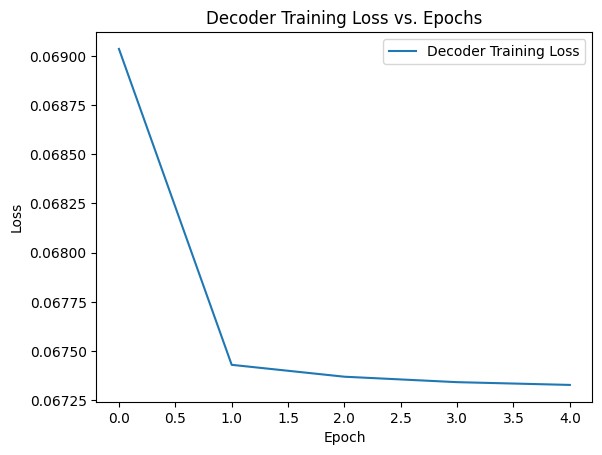

In [ ]:
# Plot the training loss as a function of epochs for encoder
plt.plot(decoder_train_losses, label='Decoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Decoder Training Loss vs. Epochs')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on validation dataset
def validate(encoder, decoder, test_loader, criterion):
    encoder.eval()
    decoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            encoded = encoder(images)
            reconstructed = decoder(encoded)
            loss = criterion(reconstructed, images)
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(test_loader.dataset)
    return val_loss

# Function to plot original and reconstructed images
def plot_images(images, reconstructions):
    num_images = min(images.size(0), 8)
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructions[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Calculate validation loss and plot reconstructed images
def validate_and_plot(encoder, decoder, test_loader, criterion):
    encoder.eval()
    decoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            encoded = encoder(images)
            reconstructed = decoder(encoded)
            loss = criterion(reconstructed, images)
            val_loss += loss.item() * images.size(0)
        
        val_loss /= len(test_loader.dataset)
        plot_images(images, reconstructed)
    return val_loss

# Calculate validation loss and plot reconstructed images
val_loss = validate_and_plot(encoder, decoder, test_loader, criterion)
print(f'Validation Loss: {val_loss}')